# Application of Vertical Federated Learning: Constructing a Credit Score System for the Unlabelled Party

Authors: Zhu Xiaochen, Xu Yunfei

## Set up the environment

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import math
import uuid
import random
import zipfile

## Data preperation

### Load the dataset

In [2]:
# Download the zip file from the internet and unzip it
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip
with zipfile.ZipFile('SouthGermanCredit.zip', 'r') as zip_ref:
    zip_ref.extractall('./SouthGermanCredit/')

--2021-07-16 09:12:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13130 (13K) [application/x-httpd-php]
Saving to: ‘SouthGermanCredit.zip’

SouthGermanCredit.z 100%[===================>]  12.82K  --.-KB/s    in 0s      

2021-07-16 09:12:58 (103 MB/s) - ‘SouthGermanCredit.zip’ saved [13130/13130]



In [3]:
original_df = pd.read_csv('./SouthGermanCredit/SouthGermanCredit.asc', sep=' ')
original_df.describe()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,1.145000,2.845000,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.845000,1.404000,1.963000,0.700000
std,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,0.477706,1.103718,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856,0.458487
min,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,1.000000,2.000000,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000
50%,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,1.000000,3.000000,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,1.000000
75%,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,1.000000,4.000000,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000
max,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,3.000000,4.000000,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000


### Vertical partition and train/test split

In [4]:
id = pd.Series(range(0,1000)).apply(lambda i : str(uuid.uuid4()))
df_with_id = original_df.copy()
df_with_id['id'] = id
df_with_id = df_with_id.set_index('id')
client1_data = df_with_id[['laufkont','sparkont','moral','verw','famges','wohn','verm','laufzeit','hoehe','beszeit']]
client2_data = df_with_id.drop(['laufkont','sparkont','moral','verw','famges','wohn','verm','laufzeit','hoehe','beszeit'], axis=1)

In [5]:
client1_train, client1_test = train_test_split(client1_data, test_size=0.2, random_state=69)
client2_train = client2_data.loc[client1_train.index]
client2_test = client2_data.loc[client1_test.index]

common_train_index = client1_train.index.intersection(client2_train.index)
common_test_index = client1_test.index.intersection(client2_test.index)

print(
    'There are {} common entries (out of {}) in client 1 and client 2\'s training datasets,\nand {} common entries (out of {}) in their test datasets'
    .format(
        len(common_train_index),
        len(client1_train),
        len(common_test_index),
        len(client1_test)))

There are 800 common entries (out of 800) in client 1 and client 2's training datasets,
and 200 common entries (out of 200) in their test datasets


## Vertical federated learning

### Parameters and helper functions

In [6]:
batch_size = 32
learning_rate = 1e-3
epochs = 50

# Instantiate an optimizer.
optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
# Instantiate a loss function.
# Not from logits because of the softmax layer converting logits to probability.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [7]:
def plot_loss(loss, accuracy):
  plt.plot(loss, label='loss')
  plt.plot(accuracy, label='accuracy')
  plt.xlabel('Epoch')
  # plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

def plot_accuracy(predictions, answers, threshold):
  tp, tn, fp, fn = 0, 0, 0, 0

  for x in range(len(predictions)):
    if answers[x] == 1:
      # if np.argmax(predictions[x]) == 1:
      if predictions[x][1] >= threshold:
        tp = tp + 1
      else:
        fn = fn + 1
    else:
      # if np.argmax(predictions[x]) == 0:
      if predictions[x][1] < threshold:
        tn = tn + 1
      else:
        fp = fp + 1
  
  accuracy = (tp + tn)/(tp + fp + fn + tn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  specificity = tn / (tn + fp)
  print("Accuracy: " + str(accuracy))
  print("Precision: " + str(precision))
  print("Recall: " + str(recall))
  # print("Specificity: " + str(specificity))
  print("F-Measure: " + str(2*(recall * precision) / (recall + precision)))

def convert_to_non_sparse(sparse):
  vector_list = np.zeros((len(sparse), 2))
  for x in range(len(sparse)):
    vector_list[x] = [1 - sparse[x], sparse[x]]
  return vector_list

### The `Client` classes

In [8]:
class Client:

  def __init__(self, train_data, test_data, labelled):
    self.__trainX = train_data.copy()
    self.__testX = test_data.copy()
    self.labelled = labelled

    if (labelled):
      self.__trainY = self.__trainX.pop('kredit')
      self.__testY = self.__testX.pop('kredit')

    normalizer = preprocessing.Normalization()
    normalizer.adapt(np.array(self.__trainX.loc[common_train_index]))

    self.model = tf.keras.Sequential([
      normalizer,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])
    
  def next_batch(self, index):
    self.batchX = self.__trainX.loc[index]
    if not self.labelled:
      grads = []
      self.model_output = np.zeros((len(index), 2))
      for i in range(len(index)):
        with tf.GradientTape() as gt:
          gt.watch(self.model.trainable_weights)
          output_by_example = self.model(self.batchX.iloc[i:i+1], training=True)
          output_for_grad = output_by_example[:,1]
        self.model_output[i] = output_by_example
        grads.append(gt.gradient(output_for_grad, self.model.trainable_weights))
      return grads
    else:
      self.batchY = self.__trainY.loc[index]
      with tf.GradientTape() as self.gt:
        self.gt.watch(self.model.trainable_weights)
        self.model_output = self.model(self.batchX, training=True)

  def cal_model(self):
    return self.model_output
  
  def predict(self, test_index):
    return self.model.predict(self.__testX.loc[test_index])# + 1e-8

  def predict_all(self, index):
    return self.model.predict(pd.concat([self.__trainX, self.__testX]).loc[index])

  def test_answers(self, test_index):
    if self.labelled:
      return self.__testY.loc[test_index]
    
  def test_answers_all(self, index):
    if self.labelled:
      return pd.concat([self.__testY, self.__trainY]).loc[index]
  
  def batch_answers(self):
    if self.labelled:
      return self.batchY

  def loss_and_update(self, a):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    self.prob = (a + self.model_output)/2
    self.c = self.coefficient_and_update()/len(self.batchX)
    return self.prob, loss_fn(self.batchY, self.prob)
  
  def coefficient_and_update(self):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    p = self.prob[:,1]
    c = (p-self.batchY)/((p)*(1-p))
    with self.gt:
      output = sum(c * self.model_output[:,1])/len(c)
    grads = self.gt.gradient(output, self.model.trainable_weights)
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
    return c
  
  def update_with(self, grads):
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

  def assemble_grad(self, partial_grads):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    # to assemble the gradient for client 1
    for i in range(len(self.c)):
      partial_grads[i] = [x * self.c[i] for x in partial_grads[i]]
    return [sum(x) for x in zip(*partial_grads)]

In [9]:
client1 = Client(client1_train, client1_test, False)
client2 = Client(client2_train, client2_test, True)

### The training loop

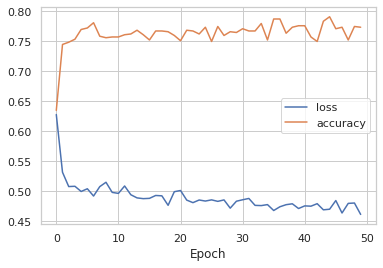

In [10]:
common_train_index_list = common_train_index.to_list()
epoch_loss = []
epoch_acc = []

for epoch in range(epochs):
  random.shuffle(common_train_index_list)
  train_index_batches = [common_train_index_list[i:i + batch_size] for i in range(0, len(common_train_index_list), batch_size)] 
  total_loss = 0.0
  # Iterate over the batches of the dataset.
  for step, batch_index in enumerate(train_index_batches):
    
    partial_grads = client1.next_batch(batch_index)
    client2.next_batch(batch_index)

    prob, loss_value = client2.loss_and_update(client1.cal_model())
    grad = client2.assemble_grad(partial_grads)
    client1.update_with(grad)
    
    total_loss = loss_value + total_loss
    train_acc_metric.update_state(client2.batch_answers(), prob)
  
  train_acc = train_acc_metric.result()
  train_acc_metric.reset_states()
  epoch_loss.append((total_loss)/(step + 1))
  epoch_acc.append(train_acc)

plot_loss(epoch_loss, epoch_acc)

### Shared model predictions on the test dataset

In [15]:
vfl_pred_test = (client1.predict(common_test_index) + client2.predict(common_test_index))/2
vfl_fpr_test, vfl_tpr_test, vfl_thresholds_test = roc_curve(client2.test_answers(common_test_index), vfl_pred_test[:,1])
vfl_gmeans_test = np.sqrt(vfl_tpr_test * (1-vfl_fpr_test))
vfl_ix_test = np.argmax(vfl_gmeans_test)
print('Best Threshold=%f, G-Mean=%.3f\n' % (vfl_thresholds_test[vfl_ix_test], vfl_gmeans_test[vfl_ix_test]))

# predictions and answers are already aligned
plot_accuracy(vfl_pred_test, client2.test_answers(common_test_index), 0.5)
print("AUC: {}".format(roc_auc_score(client2.test_answers(common_test_index), vfl_pred_test[:,1])))

Best Threshold=0.706160, G-Mean=0.729

Accuracy: 0.755
Precision: 0.7884615384615384
Recall: 0.8848920863309353
F-Measure: 0.8338983050847457
AUC: 0.7548059912725558


## Construct a credit score system via scorecarding

From here, everything happens on the unlabelled party, where we aim to construct a credit score system for it using the labels from the shared model and via the scorecard technique.

### Label client 1's dataset

With the shared model, we first label client 1's unlabelled dataset as a starting point of constructing credit scores for it.

In [16]:
# Previously, threshold is chosen from the predictions on the test dataset.
# To label all the data for client 1, we choose a threshold based on the prediction for all entries instead.
vfl_pred = (client1.predict_all(df_with_id.index) + client2.predict_all(df_with_id.index))/2
vfl_fpr, vfl_tpr, vfl_thresholds = roc_curve(client2.test_answers_all(df_with_id.index), vfl_pred[:,1])
vfl_gmeans = np.sqrt(vfl_tpr * (1-vfl_fpr))
vfl_ix = np.argmax(vfl_gmeans)
print('With Best Threshold=%f, G-Mean=%.3f:' % (vfl_thresholds[vfl_ix], vfl_gmeans[vfl_ix]))
# predictions and answers are already aligned
plot_accuracy(vfl_pred, client2.test_answers_all(df_with_id.index), vfl_thresholds[vfl_ix])
print("AUC: {}".format(roc_auc_score(client2.test_answers_all(df_with_id.index), vfl_pred[:,1])))

print('\nWith Default Threshold=0.5:')
plot_accuracy(vfl_pred, client2.test_answers_all(df_with_id.index), 0.5)
print("AUC: {}".format(roc_auc_score(client2.test_answers_all(df_with_id.index), vfl_pred[:,1])))

With Best Threshold=0.706160, G-Mean=0.757:
Accuracy: 0.742
Precision: 0.8932384341637011
Recall: 0.7171428571428572
F-Measure: 0.7955625990491284
AUC: 0.821795238095238

With Default Threshold=0.5:
Accuracy: 0.782
Precision: 0.812987012987013
Recall: 0.8942857142857142
F-Measure: 0.8517006802721089
AUC: 0.821795238095238


In [17]:
data = client1_data.copy()
data['label'] = vfl_pred[:,1]
data['label'] = data['label'].map(lambda x: 1 if x >= 0.5 else 0)

In [18]:
X = pd.concat([client1_train, client1_test])
y = data['label'].loc[X.index]
X_train = client1_train.copy()
X_test = client1_test.copy()
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

### Check the correlation among the features

In [19]:
X_train_cat = X_train[['laufkont','sparkont','moral','verw','famges','wohn','verm']]
X_train_num = X_train.drop(columns = ['laufkont','sparkont','moral','verw','famges','wohn','verm'], axis = 1)

chi2_check = {}

for column in X_train_cat:
  chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
  chi2_check.setdefault('Feature',[]).append(column)
  chi2_check.setdefault('p-value',[]).append(round(p, 10))

chi2_result = pd.DataFrame(chi2_check).sort_values('p-value')
chi2_result
# Let's use them all

,Feature,p-value
0,laufkont,0.000000
1,sparkont,0.000000
2,moral,0.000000
6,verm,0.000000
5,wohn,0.000002
4,famges,0.003234
3,verw,0.206453


In [20]:
F_statistic, p_values = f_classif(X_train_num, y_train)

ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,'F-Score': F_statistic,'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,laufzeit,117.434865,0.000000e+00
1,hoehe,45.740036,0.000000e+00
2,beszeit,38.073777,1.100000e-09


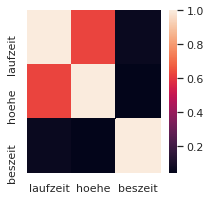

In [21]:
corrmat = X_train_num.corr()
plt.figure(figsize=(3,3))
sns.heatmap(corrmat)

### Calculate WoE and IV for each feature

In [22]:
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

sns.set()
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

#### Categorical features

In [23]:
display(woe_discrete(X,'laufkont',y_train))
display(woe_discrete(X_train,'sparkont',y_train))
display(woe_discrete(X,'moral',y_train))
display(woe_discrete(X_train,'verw',y_train))
display(woe_discrete(X_train,'famges',y_train))
display(woe_discrete(X_train,'wohn',y_train))
display(woe_discrete(X_train,'verm',y_train))

,laufkont,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,1,218,0.481651,0.27250,105.0,113.0,0.171010,0.607527,-1.267676,NaN,NaN,2.494073
1,2,210,0.676190,0.26250,142.0,68.0,0.231270,0.365591,-0.457929,0.194539,0.809747,2.494073
2,3,51,0.960784,0.06375,49.0,2.0,0.079805,0.010753,2.004425,0.284594,2.462354,2.494073
3,4,321,0.990654,0.40125,318.0,3.0,0.517915,0.016129,3.469191,0.029870,1.464766,2.494073


,sparkont,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,1,470,0.693617,0.5875,326.0,144.0,0.530945,0.774194,-0.377164,NaN,NaN,0.563934
1,2,86,0.697674,0.1075,60.0,26.0,0.097720,0.139785,-0.358000,0.004057,0.019164,0.563934
2,3,50,0.900000,0.0625,45.0,5.0,0.073290,0.026882,1.002976,0.202326,1.360977,0.563934
3,4,40,0.900000,0.0500,36.0,4.0,0.058632,0.021505,1.002976,0.000000,0.000000,0.563934
4,5,154,0.954545,0.1925,147.0,7.0,0.239414,0.037634,1.850274,0.054545,0.847298,0.563934


,moral,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0,32,0.281250,0.04000,9.0,23.0,0.014658,0.123656,-2.132518,NaN,NaN,1.032975
1,1,37,0.324324,0.04625,12.0,25.0,0.019544,0.134409,-1.928217,0.043074,0.204300,1.032975
2,2,427,0.735363,0.53375,314.0,113.0,0.511401,0.607527,-0.172243,0.411039,1.755974,1.032975
3,3,68,0.794118,0.08500,54.0,14.0,0.087948,0.075269,0.155678,0.058755,0.327922,1.032975
4,4,236,0.953390,0.29500,225.0,11.0,0.366450,0.059140,1.823957,0.159272,1.668278,1.032975


,verw,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,10,8,0.625000,0.01000,5.0,3.0,0.008143,0.016129,-0.683423,NaN,NaN,0.085335
1,6,45,0.688889,0.05625,31.0,14.0,0.050489,0.075269,-0.399318,0.063889,0.284104,0.085335
2,9,72,0.694444,0.09000,50.0,22.0,0.081433,0.118280,-0.373268,0.005556,0.026051,0.085335
3,4,10,0.700000,0.01250,7.0,3.0,0.011401,0.016129,-0.346950,0.005556,0.026317,0.085335
4,2,147,0.727891,0.18375,107.0,40.0,0.174267,0.215054,-0.210299,0.027891,0.136652,0.085335
5,8,8,0.750000,0.01000,6.0,2.0,0.009772,0.010753,-0.095636,0.022109,0.114663,0.085335
6,0,186,0.758065,0.23250,141.0,45.0,0.229642,0.241935,-0.052151,0.008065,0.043485,0.085335
7,1,82,0.817073,0.10250,67.0,15.0,0.109121,0.080645,0.302394,0.059009,0.354545,0.085335
8,3,224,0.825893,0.28000,185.0,39.0,0.301303,0.209677,0.362546,0.008820,0.060152,0.085335
9,5,18,0.833333,0.02250,15.0,3.0,0.024430,0.016129,0.415190,0.007440,0.052644,0.085335


,famges,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,1,41,0.658537,0.05125,27.0,14.0,0.043974,0.075269,-0.537469,NaN,NaN,0.117238
1,2,247,0.724696,0.30875,179.0,68.0,0.291531,0.365591,-0.226370,0.066160,0.311099,0.117238
2,3,443,0.778781,0.55375,345.0,98.0,0.561889,0.526882,0.064329,0.054085,0.290699,0.117238
3,4,69,0.913043,0.08625,63.0,6.0,0.102606,0.032258,1.157127,0.134262,1.092798,0.117238


,wohn,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,3,88,0.625000,0.1100,55.0,33.0,0.089577,0.177419,-0.683423,NaN,NaN,0.171358
1,1,146,0.664384,0.1825,97.0,49.0,0.157980,0.263441,-0.511358,0.039384,0.172065,0.171358
2,2,566,0.816254,0.7075,462.0,104.0,0.752443,0.559140,0.296926,0.151871,0.808283,0.171358


,verm,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,4,127,0.598425,0.15875,76.0,51.0,0.123779,0.274194,-0.795341,NaN,NaN,0.450919
1,3,272,0.720588,0.34000,196.0,76.0,0.319218,0.408602,-0.246867,0.122163,0.548474,0.450919
2,2,188,0.771277,0.23500,145.0,43.0,0.236156,0.231183,0.021285,0.050688,0.268152,0.450919
3,1,213,0.924883,0.26625,197.0,16.0,0.320847,0.086022,1.316367,0.153606,1.295081,0.450919


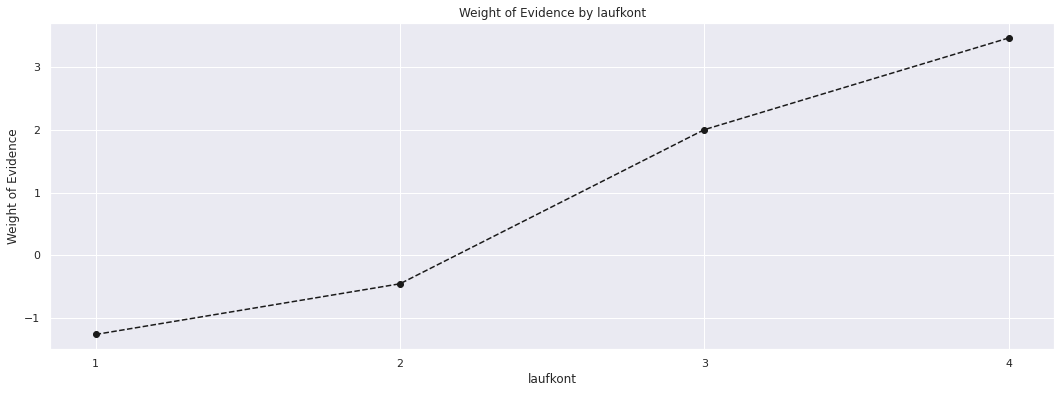

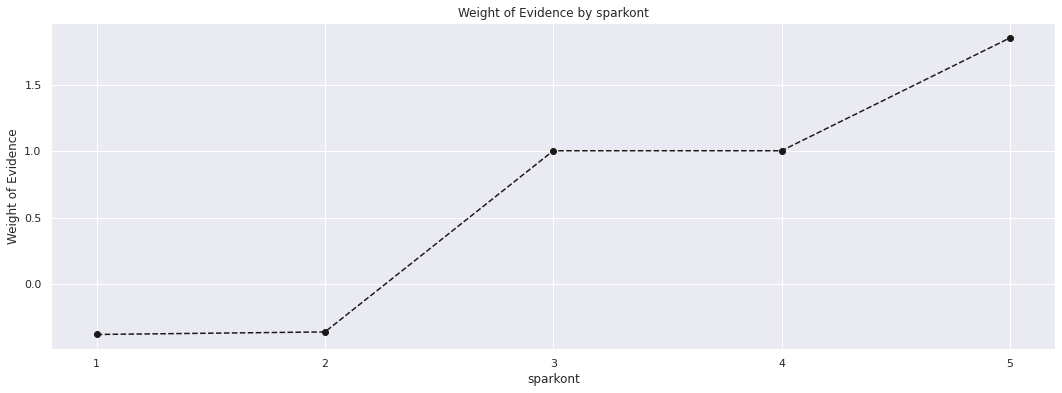

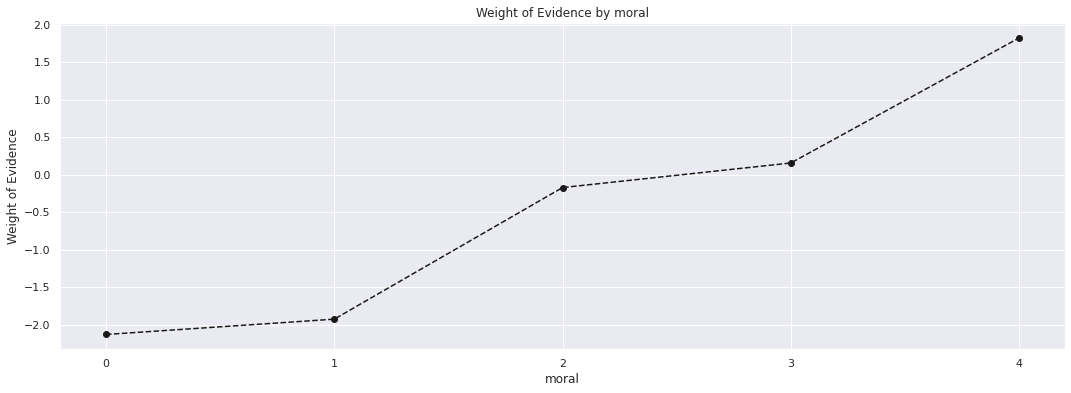

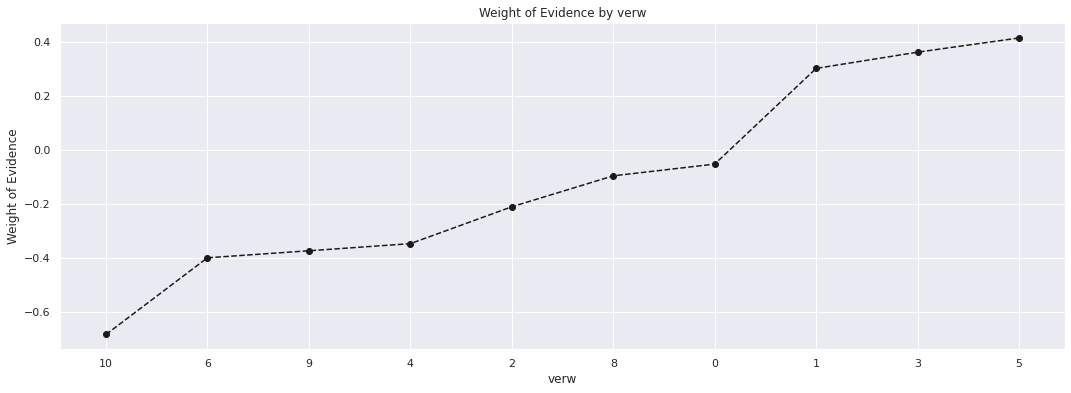

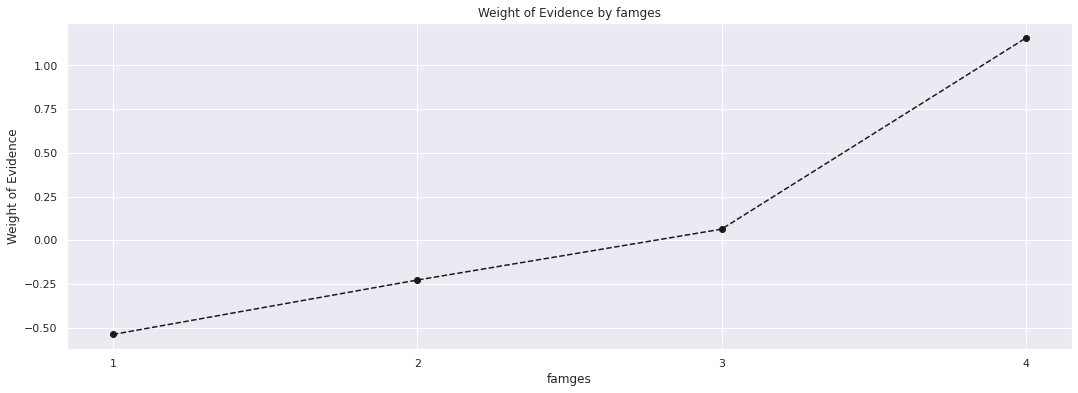

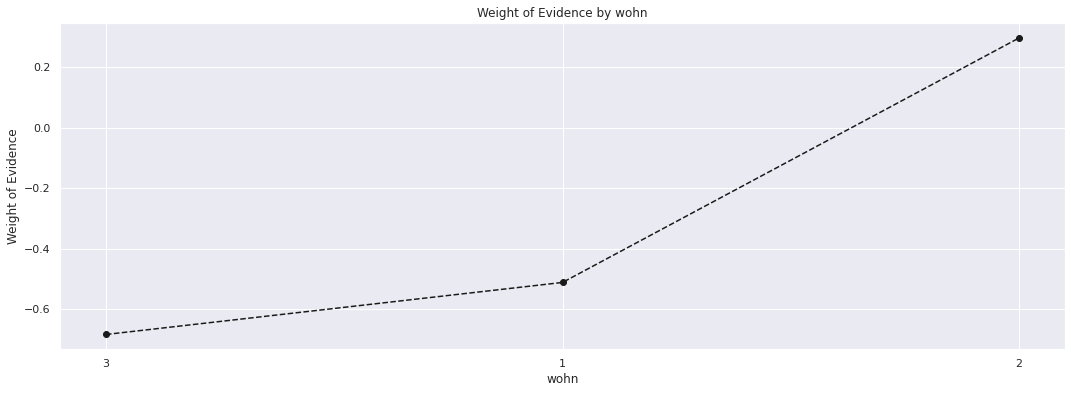

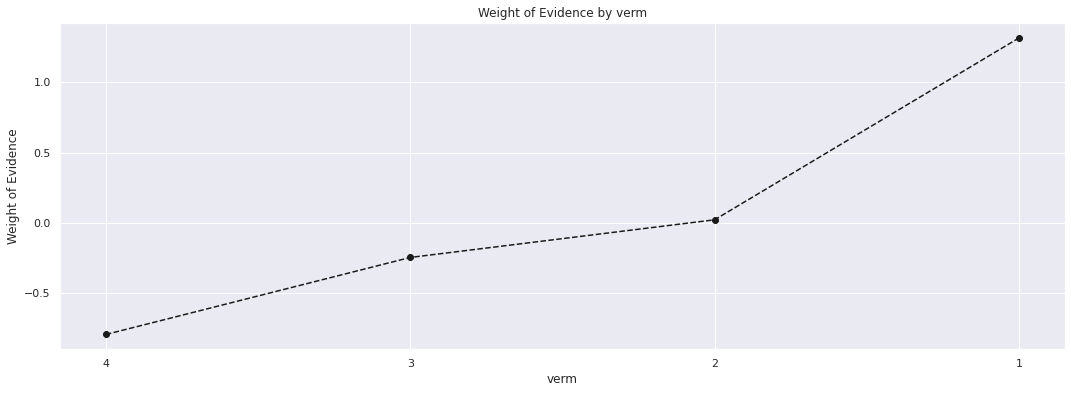

In [24]:
plot_by_woe(woe_discrete(X_train,'laufkont',y_train)) # [1], [2], [3], [4]
plot_by_woe(woe_discrete(X_train,'sparkont',y_train)) # [1,2],[3,4],[5]
plot_by_woe(woe_discrete(X_train,'moral',y_train)) #[0, 1], [2,3], [4]
plot_by_woe(woe_discrete(X_train,'verw',y_train)) # [10],[6,9,4],[2],[8,0],[1,3,5]
plot_by_woe(woe_discrete(X_train,'famges',y_train)) # [1], [2], [3], [4]
plot_by_woe(woe_discrete(X_train,'wohn',y_train)) # [1], [3], [2]
plot_by_woe(woe_discrete(X_train,'verm',y_train)) # [1] [2] [3] [4]

#### Numerical features

In [25]:
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()

,beszeit,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.996, 2.0]",189,0.603175,0.23625,114.0,75.0,0.185668,0.403226,-0.775538,NaN,NaN,0.290039
1,"(2.0, 3.0]",279,0.788530,0.34875,220.0,59.0,0.358306,0.317204,0.121842,0.185356,0.897380,0.290039
2,"(3.0, 4.0]",139,0.798561,0.17375,111.0,28.0,0.180782,0.150538,0.183077,0.010031,0.061236,0.290039
3,"(4.0, 5.0]",193,0.875648,0.24125,169.0,24.0,0.275244,0.129032,0.757597,0.077087,0.574519,0.290039


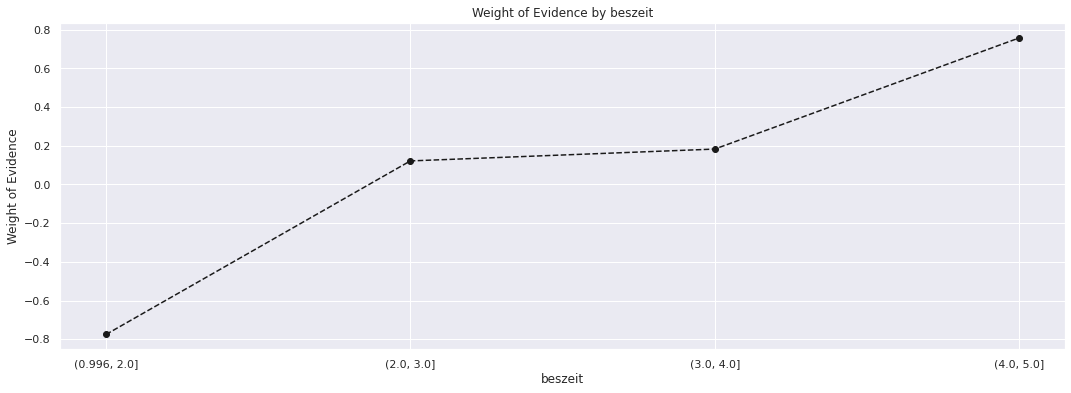

In [26]:
X_train_prepr['beszeit'] = pd.cut(X_train['beszeit'], 4)
df_temp = woe_ordered_continuous(X_train_prepr, 'beszeit', y_train_prepr)
display(df_temp)
plot_by_woe(df_temp)
# [1,2], [3,4], [5]

,laufzeit,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(3.999, 10.0]",138,0.971014,0.17250,134.0,4.0,0.218241,0.021505,2.317297,NaN,NaN,0.927755
1,"(10.0, 12.0]",149,0.845638,0.18625,126.0,23.0,0.205212,0.123656,0.506539,0.125377,1.810758,0.927755
2,"(12.0, 15.0]",58,0.844828,0.07250,49.0,9.0,0.079805,0.048387,0.500347,0.000810,0.006192,0.927755
3,"(15.0, 21.0]",128,0.820312,0.16000,105.0,23.0,0.171010,0.123656,0.324218,0.024515,0.176130,0.927755
4,"(21.0, 24.0]",149,0.718121,0.18625,107.0,42.0,0.174267,0.225806,-0.259089,0.102192,0.583307,0.927755
5,"(24.0, 36.0]",106,0.603774,0.13250,64.0,42.0,0.104235,0.225806,-0.773035,0.114347,0.513946,0.927755
6,"(36.0, 72.0]",72,0.402778,0.09000,29.0,43.0,0.047231,0.231183,-1.588153,0.200996,0.815118,0.927755


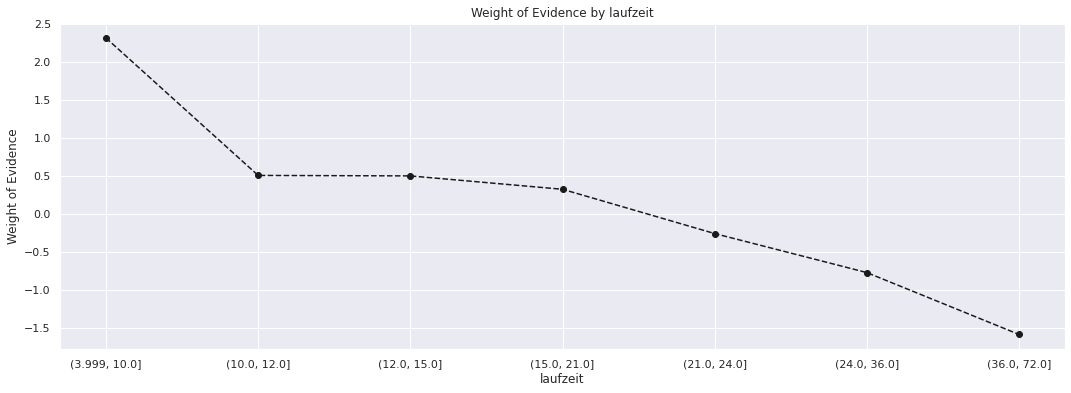

In [29]:
X_train_prepr['laufzeit'] = pd.qcut(X_train['laufzeit'], q=7)
df_temp = woe_ordered_continuous(X_train_prepr, 'laufzeit', y_train_prepr)
display(df_temp)
plot_by_woe(df_temp)
# (0,10], (10,15], (15,21], (21,24] (24,36], (36,72]

,hoehe,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(234.578, 3334.4]",522,0.827586,0.65250,432.0,90.0,0.703583,0.483871,0.374368,NaN,NaN,0.251533
1,"(3334.4, 6418.8]",171,0.690058,0.21375,118.0,53.0,0.192182,0.284946,-0.393856,0.137528,0.768223,0.251533
2,"(6418.8, 9503.2]",72,0.666667,0.09000,48.0,24.0,0.078176,0.129032,-0.501101,0.023392,0.107246,0.251533
3,"(9503.2, 12587.6]",22,0.500000,0.02750,11.0,11.0,0.017915,0.059140,-1.194248,0.166667,0.693147,0.251533
4,"(12587.6, 15672.0]",13,0.384615,0.01625,5.0,8.0,0.008143,0.043011,-1.664252,0.115385,0.470004,0.251533


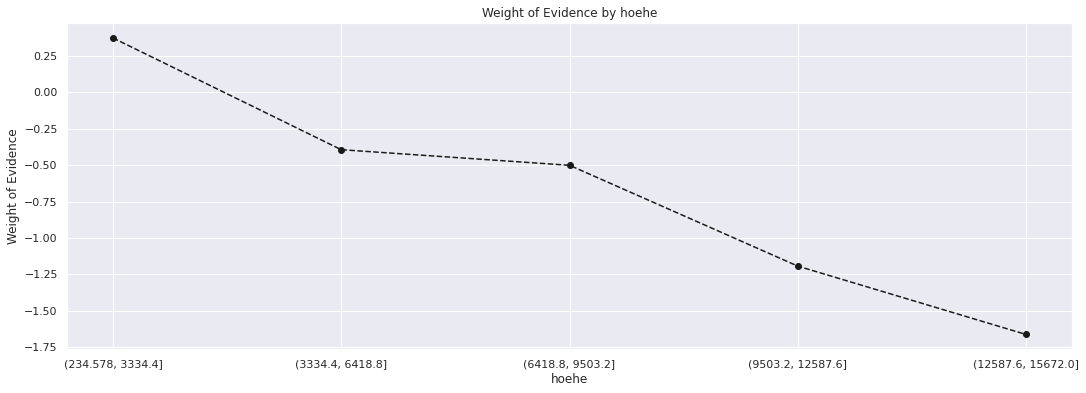

In [33]:
X_train_prepr['hoehe'] = pd.cut(X_train['hoehe'], 5)
df_temp = woe_ordered_continuous(X_train_prepr, 'hoehe', y_train_prepr)
display(df_temp)
plot_by_woe(df_temp)
#Bin into: (, 3334],(3334, 9503],(9503, 12587],(12587, 15672]

### Binning based on WoE

According to previous section, we have the following features:


In [34]:
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

X_train = dummy_creation(X_train, ['laufkont', 'sparkont', 'verw', 'moral', 'famges', 'wohn', 'verm'])
X_test = dummy_creation(X_test, ['laufkont', 'sparkont', 'verw', 'moral', 'famges', 'wohn', 'verm'])

In [ ]:
# 'laufkont' [1], [2], [3], [4]
# 'sparkont' [1,2],[3,4],[5]
# 'moral' [0,1], [2,3], [4]
# 'verw' [10],[6,9,4],[2],[8,0],[1,3,5]
# 'famges' [1], [2], [3], [4]
# 'wohn' [1], [3], [2]
# 'verm' [1] [2] [3] [4]

# 'beszeit' [1,2], [3,4], [5]
# `hoehe` (, 3334],(3334, 9503],(9503, 12587],(12587, 15672]
# `laufzeit`(0,10], (10,15], (15,21], (21,24] (24,36], (36,72]

In [41]:
ref_categories = []

class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X):
        self.X = X

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X_new = X.loc[:,'verm:4':'verm:1']

        X_new['laufkont:1'] = X.loc[:,'laufkont:1']
        X_new['laufkont:2'] = X.loc[:,'laufkont:2']
        X_new['laufkont:3'] = X.loc[:,'laufkont:3']
        X_new['laufkont:4'] = X.loc[:,'laufkont:4']

        X_new['verw:1,3,5'] = np.where(((X['verw'] == 1) | (X['verw'] == 3) | (X['verw'] == 5)), 1, 0)
        X_new['verw:2'] = np.where((X['verw'] == 2), 1, 0)
        X_new['verw:4,6,9'] = np.where(((X['verw'] == 4) | (X['verw'] == 6) | (X['verw'] == 9)), 1, 0)
        X_new['verw:0,8'] = np.where(((X['verw'] == 0) | (X['verw'] == 8)), 1, 0)
        X_new['verw:10'] = np.where((X['verw'] == 10), 1, 0)

        X_new['sparkont:1-2'] = np.where((X['sparkont'] <= 2), 1, 0)
        X_new['sparkont:3-4'] = np.where(((X['sparkont'] >=3) & (X['sparkont'] <= 4)), 1, 0)
        X_new['sparkont:5'] = np.where((X['sparkont'] == 5), 1, 0)

        X_new['moral:0-1'] = np.where((X['moral']<= 1), 1, 0)
        X_new['moral:2-3'] = np.where(((X['moral'] >= 2) & (X['moral'] <= 3)), 1, 0)
        X_new['moral:4'] = np.where((X['moral'] == 4), 1, 0)

        X_new['famges:1'] = np.where((X['famges'] == 1), 1, 0)
        X_new['famges:2'] = np.where((X['famges'] == 2), 1, 0)
        X_new['famges:3'] = np.where((X['famges'] == 3), 1, 0)
        X_new['famges:4'] = np.where((X['famges'] == 4), 1, 0)

        X_new['wohn:1'] = np.where((X['wohn'] == 1), 1, 0)
        X_new['wohn:2'] = np.where((X['wohn'] == 2), 1, 0)
        X_new['wohn:3'] = np.where((X['wohn'] == 3), 1, 0)

        X_new['laufzeit:<=10'] = np.where((X['laufzeit'] <= 10), 1, 0)
        X_new['laufzeit:11-15'] = np.where(((X['laufzeit'] >= 11) & (X['laufzeit'] <= 15)), 1, 0)
        X_new['laufzeit:16-21'] = np.where(((X['laufzeit'] >= 16) & (X['laufzeit'] <= 21)), 1, 0)
        X_new['laufzeit:22-24'] = np.where(((X['laufzeit'] >= 22) & (X['laufzeit'] <= 24)), 1, 0)
        X_new['laufzeit:25-36'] = np.where(((X['laufzeit'] >= 25) & (X['laufzeit'] <= 36)), 1, 0)
        X_new['laufzeit:>=37'] = np.where((X['laufzeit'] >= 37), 1, 0)

        X_new['hoehe:<=3334'] = np.where((X['hoehe'] <= 3334), 1, 0)
        X_new['hoehe:3335-9503'] = np.where(((X['hoehe'] >= 3335) & (X['hoehe'] <= 9503)), 1, 0)
        X_new['hoehe:9504-12587'] = np.where(((X['hoehe'] >= 9504) & (X['hoehe'] <= 12587)), 1, 0)
        X_new['hoehe:>=12588'] = np.where((X['hoehe'] >= 12588), 1, 0)

        X_new['beszeit:1-2'] = np.where((X['beszeit'] <= 2), 1, 0)
        X_new['beszeit:3-4'] = np.where(((X['beszeit'] >= 3) & (X['beszeit'] <= 4)), 1, 0)
        X_new['beszeit:5'] = np.where((X['beszeit'] == 5), 1, 0)

        X_new.drop(columns = ref_categories, inplace = True)
        return X_new

### Logistic regression

In [42]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.9665
Gini: 0.9331


In [43]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('woe',
                 WoE_Binning(X=                                      laufkont  sparkont  moral  verw  famges  \
id                                                                              
4d4bff50-8def-4def-b676-7ceb957a9930         2         1      4     2       2   
4736844d-dfaa-4636-9a5d-6e5503af84c6         4         5      4     1       3   
f02ac442-b4a9-45a3-a760-c9602207e975         1         1      4     0       3   
028fc231-d9b0-4041-baa2-6c16c7bd7305         3         5      2     3       3   
ef6db9e0-2b58-4fde-99df-50e9c2844ca6         4         2      4     3       2   
c8b6e3df-54ed-4fee-801a-9517e48c6d0a         1         1      2     0       3   
0c98d9b7-fdd0-4502-98...
86a7f158-db2d-4b3f-bd63-e146e7e562a1     2     3        24   1559        4  
7e53320e-ec21-427d-98f5-adaa048ab02e     2     3         6    426        5  )),
                ('model',
                 LogisticRegression(C=1.0, class_weight='balanced',

In [44]:
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,1.485916
1,laufkont:1,-2.579506
2,laufkont:2,-0.967127
3,laufkont:3,1.031573
4,laufkont:4,2.515328
5,"verw:1,3,5",0.058677
6,verw:2,0.080312
7,"verw:4,6,9",-0.222733
8,"verw:0,8",-0.448397
9,verw:10,0.532410


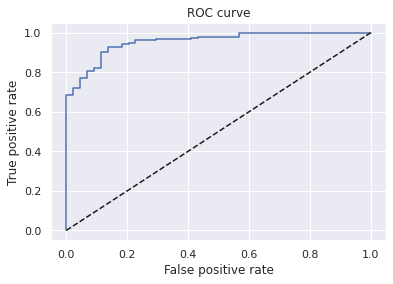

In [45]:
y_hat_test = pipeline.predict(X_test)
y_hat_test_proba = pipeline.predict_proba(X_test)
y_hat_test_proba = y_hat_test_proba[:][: , 1]

y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
y_test_proba.index = X_test.index

fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'],y_test_proba['y_hat_test_proba'])
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

AUROC: 0.9554
Gini: 0.9108


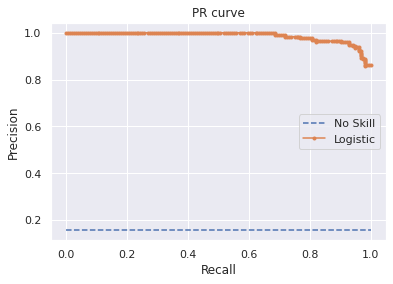

In [46]:
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
Gini = AUROC * 2 - 1
print('AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (Gini))

no_skill = len(y_test[y_test == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [47]:
auc_pr = auc(recall, precision)
auc_pr

0.9870912226596767

### Construct credit scores

In [48]:
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list. We name it 'Feature name'.
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0

# Concatenates two dataframes.
df_scorecard = pd.concat([summary_table, df_ref_categories])
# We reset the index of a dataframe.
df_scorecard.reset_index(inplace = True)
df_scorecard

,index,Feature name,Coefficients
0,0,Intercept,1.485916
1,1,laufkont:1,-2.579506
2,2,laufkont:2,-0.967127
3,3,laufkont:3,1.031573
4,4,laufkont:4,2.515328
5,5,"verw:1,3,5",0.058677
6,6,verw:2,0.080312
7,7,"verw:4,6,9",-0.222733
8,8,"verw:0,8",-0.448397
9,9,verw:10,0.532410


In [49]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Feature name,Coefficients,Original feature name
0,0,Intercept,1.485916,Intercept
1,1,laufkont:1,-2.579506,laufkont
2,2,laufkont:2,-0.967127,laufkont
3,3,laufkont:3,1.031573,laufkont
4,4,laufkont:4,2.515328,laufkont
5,5,"verw:1,3,5",0.058677,verw
6,6,verw:2,0.080312,verw
7,7,"verw:4,6,9",-0.222733,verw
8,8,"verw:0,8",-0.448397,verw
9,9,verw:10,0.532410,verw


In [50]:
# Define the min and max threshholds for our scorecard
min_score = 600
max_score = 850

# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,1.485916,Intercept,723.056190,723.0
1,1,laufkont:1,-2.579506,laufkont,-27.056327,-27.0
2,2,laufkont:2,-0.967127,laufkont,-10.144154,-10.0
3,3,laufkont:3,1.031573,laufkont,10.820131,11.0
4,4,laufkont:4,2.515328,laufkont,26.383170,26.0
5,5,"verw:1,3,5",0.058677,verw,0.615458,1.0
6,6,verw:2,0.080312,verw,0.842391,1.0
7,7,"verw:4,6,9",-0.222733,verw,-2.336236,-2.0
8,8,"verw:0,8",-0.448397,verw,-4.703217,-5.0
9,9,verw:10,0.532410,verw,5.584423,6.0


In [51]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

601.0
849.0


### Credit score performance on the test data

In [68]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,laufkont:1,laufkont:2,laufkont:3,laufkont:4,"verw:1,3,5",verw:2,"verw:4,6,9","verw:0,8",verw:10,sparkont:1-2,sparkont:3-4,sparkont:5,moral:0-1,moral:2-3,moral:4,famges:1,famges:2,famges:3,famges:4,wohn:1,wohn:2,wohn:3,laufzeit:<=10,laufzeit:11-15,laufzeit:16-21,laufzeit:22-24,laufzeit:25-36,laufzeit:>=37,hoehe:<=3334,hoehe:3335-9503,hoehe:9504-12587,hoehe:>=12588,beszeit:1-2,beszeit:3-4,beszeit:5
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8657af1c-c8f9-4d99-81d4-1edcf3f93707,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
b502645f-1294-4b00-9702-a9befb6c56a6,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
1b804b47-4439-4023-a9ad-0557009d64e4,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
45fc8b5f-c94e-4170-85fd-d4e121ee18f2,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
ec74ed2c-d722-42e4-8251-54d98fbede02,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0


In [69]:
# get the list of our final scorecard scores
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(200, 36)
(36,)


In [70]:
# we can see that the test set has 2 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard, it is safe to add these categories to the end of test set with 0 values
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                         index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is (36,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(36, 1)

# We have the scores!
y_scores = X_test_woe_transformed.dot(scorecard_scores)

In [71]:
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()

def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']

Best Threshold: 0.295432


In [72]:
df_cutoffs.loc[ix]

thresholds          0.295432
Score             698.000000
N Approved        153.000000
N Rejected         47.000000
Approval Rate       0.765000
Rejection Rate      0.235000
Name: 28, dtype: float64

In [85]:
labels_from_scores = y_scores.iloc[:,0].map(lambda x: 1 if x >= 698 else 0)
actual_1s_index = y_test[y_test == 1].index
actual_0s_index = y_test[y_test == 0].index
tp = labels_from_scores.loc[actual_1s_index].sum()
fp = labels_from_scores.loc[actual_0s_index].sum()
fn = labels_from_scores.loc[actual_1s_index].map(lambda x: 1 if x == 0 else 0).sum()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision * recall)/(precision + recall)
print("On the optimal cut-off score against VFL predicted labels:")
print('Accuracy: ' + str(1-abs(labels_from_scores - y_test).sum()/len(y_test)))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1 score: ' + str(f1))

On the optimal cut-off score against VFL predicted labels:
Accuracy: 0.91
Precision: 0.9423076923076923
Recall: 0.9423076923076923
F1 score: 0.9423076923076923


Therefore, scorecard can give credit scores which lead to very accurate label predictions with an approporiate threshold. Although the labels being used here are not quite accurate, given a VFL model with better learning outcome, the credit scores can be very accurate.